# Fedbiomed to train a federated SGD regressor model

## Data 


This tutorial shows how to deploy in Fed-BioMed to solve a federated regression problem with scikit-learn.

In this tutorial we are using the wrapper of Fed-BioMed for the SGD regressor (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html).
The goal of the notebook is to train a model on a realistic dataset of (synthetic) medical information mimicking the ADNI dataset (http://adni.loni.usc.edu/). 

## Creating nodes

To proceed with the tutorial, we create 3 clients with corresponding dataframes of clinical information in .csv format. Each client has 300 data points composed by several features corresponding to clinical and medical imaging informations. **The data is entirely synthetic and randomly sampled to mimick the variability of the real ADNI dataset**. The training partitions are availables at the following link:

https://drive.google.com/file/d/1R39Ir60oQi8ZnmHoPz5CoGCrVIglcO9l/view?usp=sharing

The federated task we aim at solve is to predict a clinical variable (the mini-mental state examination, MMSE) from a combination of demographic and imaging features. The regressors variables are the following features:

['SEX', 'AGE', 'PTEDUCAT', 'WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']

and the target variable is:

['MMSE.bl']
    

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 
After activating the fedbiomed network with the commands

`source ./scripts/fedbiomed_environment network`

and 

`./scripts/fedbiomed_run network`

we create a first node by using the commands

`source ./scripts/fedbiomed_environment node`

`./scripts/fedbiomed_run node start`

We then poulate the node with the data of first client:

`./scripts/fedbiomed_run node config conf.ini add`

Thn, we select option 1 (csv dataset) to add the .csv partition of client 1, by just picking the .csv of client 1. We use `adni` as tag to save the selected dataset. We can further check that the data has been added by executing `./scripts/fedbiomed_run node list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively. To do so, we add and launch a `Node`using others configuration files

## Fed-BioMed Researcher

We are now ready to start the reseracher enviroment with the command `source ./scripts/fedbiomed_environment researcher`, and open the Jupyter notebook with `./scripts/fedbiomed_run researcher`. 

We can first query the network for the adni dataset. In this case, the nodes are sharing the respective partitions unsing the same tag `adni`:

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-01-17 11:50:47,600 fedbiomed INFO - Component environment:
2022-01-17 11:50:47,601 fedbiomed INFO - - type = ComponentType.RESEARCHER
2022-01-17 11:50:47,964 fedbiomed INFO - Messaging researcher_997cf677-db35-49e8-a283-61f04921355e successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x7ff7c845a3d0>
2022-01-17 11:50:48,011 fedbiomed INFO - Listing available datasets in all nodes... 
2022-01-17 11:50:48,013 fedbiomed INFO - log from: node_26f70655-a3da-48c9-9909-06dc0cbf70c0 / DEBUG - Message received: {'researcher_id': 'researcher_997cf677-db35-49e8-a283-61f04921355e', 'command': 'list'}
2022-01-17 11:50:48,014 fedbiomed INFO - log from: node_e635e3a9-0f5d-4b9c-940e-8265ed9eb0d3 / DEBUG - Message received: {'researcher_id': 'researcher_997cf677-db35-49e8-a283-61f04921355e', 'command': 'list'}
2022-01-17 11:50:48,026 fedbiomed INFO - log from: node_75660f7f-a463-41d1-a132-2506f05d6a51 / DEBUG - Message received: {'researcher_id': '

{'node_26f70655-a3da-48c9-9909-06dc0cbf70c0': [{'name': 'adni',
   'data_type': 'csv',
   'tags': ['adni'],
   'description': '',
   'shape': [300, 20]}],
 'node_e635e3a9-0f5d-4b9c-940e-8265ed9eb0d3': [{'name': 'adni',
   'data_type': 'csv',
   'tags': ['adni'],
   'description': '',
   'shape': [300, 20]}],
 'node_75660f7f-a463-41d1-a132-2506f05d6a51': [{'name': 'adni',
   'data_type': 'csv',
   'tags': ['adni'],
   'description': '',
   'shape': [300, 20]}]}

In [3]:
from fedbiomed.researcher.environ import environ
import tempfile
import os
tmp_dir_model = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+os.sep)
model_file = os.path.join(tmp_dir_model.name, 'fedbiosklearn.py')

## Create an experiment to train a model on the data found

The code for network and data loader of the sklearn SGDRegressor can now be deployed in Fed-BioMed.
We first import the necessary module `SGDSkLearnModel` from `fedbiomed`:

**__init__** : we add here the needed sklearn libraries
       
**training_data** : you must return here a tuple (data,targets) that must be of the same type of 
your method partial_fit parameters. 

We note that this model performs a common standardization across federated datasets by **centering with respect to the same parameters**.

In [4]:
%%writefile "$model_file"

from fedbiomed.common.fedbiosklearn import SGDSkLearnModel
from sklearn.linear_model import SGDRegressor


class SGDRegressorTrainingPlan(SGDSkLearnModel):
    def __init__(self, kwargs):
        super(SGDRegressorTrainingPlan, self).__init__(kwargs)
        self.add_dependency(["from sklearn.linear_model import SGDRegressor"])
    
    def training_data(self):
        dataset = pd.read_csv(self.dataset_path,delimiter=',')
        regressors_col = ['SEX', 'AGE', 'PTEDUCAT', 'WholeBrain.bl',
                          'Ventricles.bl', 'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']
        target_col = ['MMSE.bl']
        
        # mean and standard deviation for normalizing dataset
        # it has been computed over the whole dataset
        scaling_mean = np.array([0.8, 72.3, 16.2, 0.7, 0.0, 0.0, 0.0, 0.0])
        scaling_sd = np.array([3.5e-01, 7.3e+00, 2.7e+00, 5.0e-02, 1.1e-02, 1.0e-03, 2.0e-03, 1.0e-03])
        
        X = (dataset[regressors_col].values-scaling_mean)/scaling_sd
        y = dataset[target_col]
        return (X,y.values.ravel())
    

Writing /home/ybouilla/fedbiomed/var/tmp/tmpw23f0e4p/fedbiosklearn.py


**model_args** is a dictionary containing your model arguments, in case of SGDRegressor this will be max_iter and tol. n_features is provided to correctly initialize the SGDRegressor coef_ array.

**training_args** is a dictionary with parameters related to Federated Learning. 

In [77]:
RANDOM_SEED = 1234


model_args = { 'max_iter':2000,
              'tol': 1e-5 ,
              'eta0':0.05,
              'model': 'SGDRegressor' ,
              'n_features': 8,
             'random_state': RANDOM_SEED}

training_args = {
    'epochs': 5, 
}

The experiment can be now defined, by providing the `adni` tag, and running the local training on nodes with model defined in `model_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be perfomed through 10 optimization rounds.

In [82]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['adni']
rounds = 40

# select nodes participing to this experiment
exp = Experiment(tags=tags,
                 #nodes=None,
                 model_path=model_file,
                 model_args=model_args,
                 model_class='SGDRegressorTrainingPlan',
                 training_args=training_args,
                 rounds=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None)

2022-01-17 16:23:41,464 fedbiomed INFO - Searching dataset with data tags: ['adni'] for all nodes
2022-01-17 16:23:41,468 fedbiomed INFO - log from: node_26f70655-a3da-48c9-9909-06dc0cbf70c0 / DEBUG - Message received: {'researcher_id': 'researcher_997cf677-db35-49e8-a283-61f04921355e', 'tags': ['adni'], 'command': 'search'}
2022-01-17 16:23:41,470 fedbiomed INFO - log from: node_75660f7f-a463-41d1-a132-2506f05d6a51 / DEBUG - Message received: {'researcher_id': 'researcher_997cf677-db35-49e8-a283-61f04921355e', 'tags': ['adni'], 'command': 'search'}
2022-01-17 16:23:41,472 fedbiomed INFO - log from: node_e635e3a9-0f5d-4b9c-940e-8265ed9eb0d3 / DEBUG - Message received: {'researcher_id': 'researcher_997cf677-db35-49e8-a283-61f04921355e', 'tags': ['adni'], 'command': 'search'}
2022-01-17 16:23:51,486 fedbiomed INFO - Node selected for training -> node_e635e3a9-0f5d-4b9c-940e-8265ed9eb0d3
2022-01-17 16:23:51,488 fedbiomed INFO - Node selected for training -> node_75660f7f-a463-41d1-a132-25

In [ ]:
# start federated training
exp.run()

##  Testing

Once the federated model is obtained, it is possible to test it locally on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1zNUGp6TMn6WSKYVC8FQiQ9lJAUdasxk1/

In [8]:
!pip install matplotlib
!pip install gdown

Download the testing dataset on the local temporary folder.

In [8]:
import os
import gdown
import zipfile

resource = "https://drive.google.com/uc?id=19kxuI146WA2fhcOU2_AvF8dy-ppJkzW7"
base_dir = tmp_dir_model.name 

test_file = os.path.join(base_dir, "test_data.zip")
gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)


Downloading...
From: https://drive.google.com/uc?id=19kxuI146WA2fhcOU2_AvF8dy-ppJkzW7
To: /home/ybouilla/fedbiomed/var/tmp/tmpw23f0e4p/test_data.zip
100%|██████████████████████████████████████| 12.4k/12.4k [00:00<00:00, 17.0MB/s]


In [71]:
import pandas as pd
import numpy as np


# loading testing dataset
test_data = pd.read_csv(os.path.join(base_dir,'adni_validation.csv'))

In [72]:
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt

In [73]:
%matplotlib inline

Here we extract the relevant regressors and target from the testing data 

In [84]:
regressors_col = ['SEX', 'AGE', 'PTEDUCAT', 'WholeBrain.bl', 'Ventricles.bl',
                  'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']
target_col = ['MMSE.bl']
X_test = test_data[regressors_col].values
y_test = test_data[target_col].values

To inspect the model evolution across FL rounds, we export `exp.aggregated_params` containing models parameters collected at the end of each round. The MSE (Mean Squarred Error) should be decreasing at each iteration with the federated parameters obtained at each round. 

Text(0, 0.5, 'testing loss (MSE)')

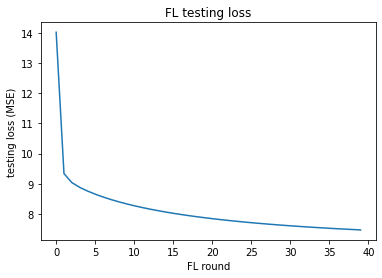

In [85]:
scaling_mean = np.array([0.8, 72.3, 16.2, 0.7, 0.0, 0.0, 0.0, 0.0])
scaling_sd = np.array([3.5e-01, 7.3e+00, 2.7e+00, 5.0e-02, 1.1e-02, 1.0e-03, 2.0e-03, 1.0e-03])

testing_error = []


# we create here several instances of SGDRegressor using same sklearn arguments
# we have used for Federated Learning training
fed_model = SGDRegressor()
regressor_args = {key: model_args[key] for key in model_args.keys() if key in fed_model.get_params().keys()}

for i in range(rounds):
    fed_model = SGDRegressor()
    fed_model.set_params(**regressor_args)
    fed_model.coef_ = exp.aggregated_params[i]['params']['coef_'].copy()
    fed_model.intercept_ = exp.aggregated_params[i]['params']['intercept_'].copy()  
    mse = np.mean((fed_model.predict((X_test-scaling_mean)/scaling_sd) - y_test)**2)
    testing_error.append(mse)

plt.plot(testing_error)
plt.title('FL testing loss')
plt.xlabel('FL round')
plt.ylabel('testing loss (MSE)')

We finally inspect the predictions of the final federated model on the testing data.

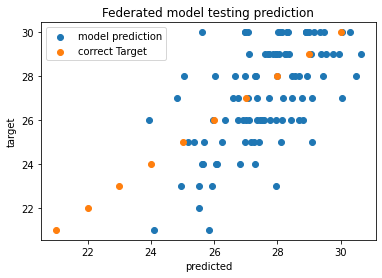

In [88]:
y_predicted = fed_model.predict((X_test-scaling_mean)/scaling_sd)
plt.scatter(y_predicted, y_test, label='model prediction')
plt.xlabel('predicted')
plt.ylabel('target')
plt.title('Federated model testing prediction')

first_diag = np.arange(np.min(y_test.flatten()),
                       np.max(y_test.flatten()+1))
plt.scatter(first_diag, first_diag, label='correct Target')
plt.legend()

In [92]:
a = X_test / scaling_sd
a.shape

(100, 8)

In [93]:
X_test.shape

(100, 8)

In [98]:
X_test[:,1] / scaling_sd[1] - a[:,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])